# Group Assignment - Social Network Analysis

In [43]:
# Importing libraries
library(htmlwidgets)
library(networkD3)
library(reshape)
library(ggplot2)
library(ggraph)
library(igraph)
library(readr)
library(dplyr)

# 1) Creating our Inputs:

In [2]:
# Importing databases
db = read.csv(file = "C:/Users/jpolancoroque/Desktop/IESEG/02. Second Semester/Social Network Analysis/Group/Industry-by-Industry Total Requirements.csv")

In [3]:
# Changing the name of the columns
names(db)[3:73] = as.character(db$Name)

In [4]:
# Only positive numbers
db[db < 0] = 0

Warning message in Ops.factor(left, right):
"'<' not meaningful for factors"
Warning message in Ops.factor(left, right):
"'<' not meaningful for factors"


In [5]:
# Creating the Nodes dataframe
nodes = as.data.frame(as.character(db$Name))
names(nodes)[names(nodes) == 'as.character(db$Name)'] = "Industry"
nodes$Industry = as.character(nodes$Industry)
glimpse(nodes)

Observations: 71
Variables: 1
$ Industry <chr> "Farms", "Forestry, fishing, and related activities", "Oil...


In [6]:
# Creating the Ties dataframe

# Pivoting the matrix
ties = melt(db) 
ties$IOCode = NULL

# Making characters in order to compare them
ties$Name = as.character(ties$Name)
ties$variable = as.character(ties$variable)

# Eliminate wrong and innecesary information
ties = ties[ties$Name != ties$variable,]
ties = ties[ties$value != 0,]

# Changing column names
names(ties)[names(ties) == 'Name'] = "src"
names(ties)[names(ties) == 'variable'] = "tgt"
names(ties)[names(ties) == 'value'] = "weight"

glimpse(ties)

Using IOCode, Name as id variables



Observations: 4,822
Variables: 3
$ src    <chr> "Forestry, fishing, and related activities", "Oil and gas ex...
$ tgt    <chr> "Farms", "Farms", "Farms", "Farms", "Farms", "Farms", "Farms...
$ weight <dbl> 0.0777526, 0.0298689, 0.0096191, 0.0011126, 0.0258397, 0.017...


In [7]:
ties$src = toupper(ties$src)
ties$tgt = toupper(ties$tgt)
nodes$Industry = toupper(nodes$Industry)

# 2) Network Analysis:

In [8]:
# Creating network dataframe
network = graph_from_data_frame(d = ties, directed = TRUE, vertices = nodes)
network

IGRAPH f84260e DNW- 71 4822 -- 
+ attr: name (v/c), weight (e/n)
+ edges from f84260e (vertex names):
 [1] FORESTRY, FISHING, AND RELATED ACTIVITIES->FARMS
 [2] OIL AND GAS EXTRACTION                   ->FARMS
 [3] MINING, EXCEPT OIL AND GAS               ->FARMS
 [4] SUPPORT ACTIVITIES FOR MINING            ->FARMS
 [5] UTILITIES                                ->FARMS
 [6] CONSTRUCTION                             ->FARMS
 [7] WOOD PRODUCTS                            ->FARMS
 [8] NONMETALLIC MINERAL PRODUCTS             ->FARMS
+ ... omitted several edges

In [9]:
# Exploring the set of nodes
V(network)

+ 71/71 vertices, named, from f84260e:
 [1] FARMS                                                               
 [2] FORESTRY, FISHING, AND RELATED ACTIVITIES                           
 [3] OIL AND GAS EXTRACTION                                              
 [4] MINING, EXCEPT OIL AND GAS                                          
 [5] SUPPORT ACTIVITIES FOR MINING                                       
 [6] UTILITIES                                                           
 [7] CONSTRUCTION                                                        
 [8] WOOD PRODUCTS                                                       
 [9] NONMETALLIC MINERAL PRODUCTS                                        
[10] PRIMARY METALS                                                      
+ ... omitted several vertices

In [10]:
# Exploring the set of ties
E(network)

+ 4822/4822 edges from f84260e (vertex names):
 [1] FORESTRY, FISHING, AND RELATED ACTIVITIES       ->FARMS
 [2] OIL AND GAS EXTRACTION                          ->FARMS
 [3] MINING, EXCEPT OIL AND GAS                      ->FARMS
 [4] SUPPORT ACTIVITIES FOR MINING                   ->FARMS
 [5] UTILITIES                                       ->FARMS
 [6] CONSTRUCTION                                    ->FARMS
 [7] WOOD PRODUCTS                                   ->FARMS
 [8] NONMETALLIC MINERAL PRODUCTS                    ->FARMS
 [9] PRIMARY METALS                                  ->FARMS
[10] FABRICATED METAL PRODUCTS                       ->FARMS
+ ... omitted several edges

In [11]:
# Naming the network dataset
network$title = 'Industry-by-Industry Total Requirements in 2018 (B USD)'

In [12]:
# Add node attribute id and print the node 'ID' attribute
V(network)$ID = seq_len(vcount(network))

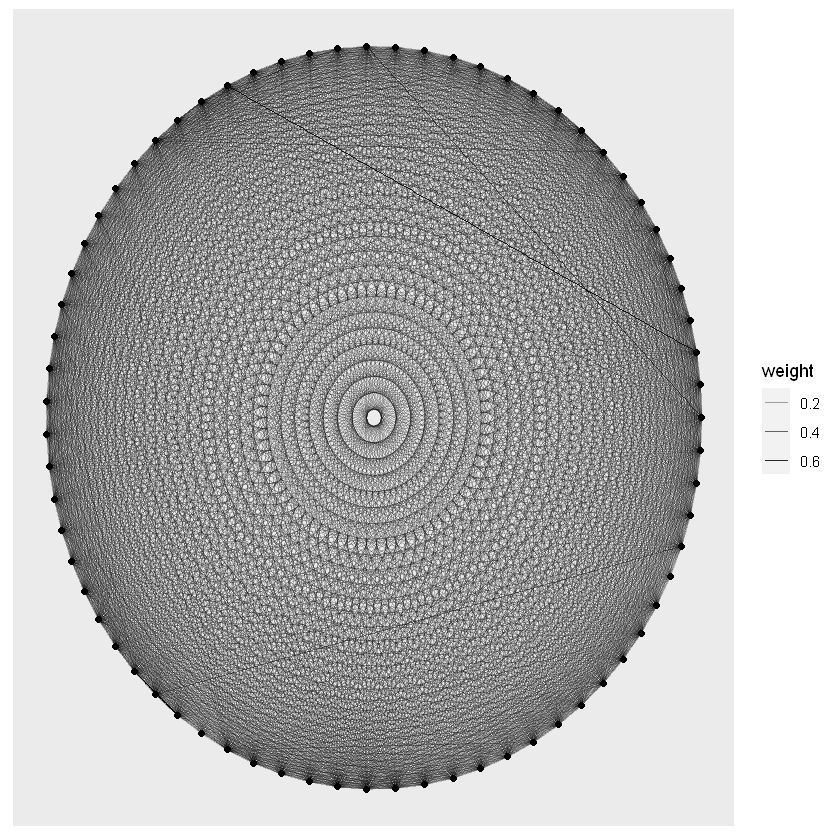

In [13]:
# Visualize the network with the Kamada-Kawai layout 
ggraph(network, layout = "in_circle") + geom_edge_link(aes(alpha = weight)) + geom_node_point()

# 3) Centrality Analysis:

In [14]:
# Compute degree
network_degree = degree(network)

# Compute node strength
network_strength = strength(network)

In [15]:
# Finding the most strongly connected customers
node_w_d_s = nodes %>% mutate(degree = network_degree, strength = network_strength) %>% arrange(desc(strength))
head(node_w_d_s)

,Industry,degree,strength
,<chr>,<dbl>,<dbl>
1,OTHER REAL ESTATE,138,4.960261
2,WHOLESALE TRADE,138,4.907303
3,"MISCELLANEOUS PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES",138,4.891323
4,ADMINISTRATIVE AND SUPPORT SERVICES,138,4.040092
5,CHEMICAL PRODUCTS,138,3.446054
6,PRIMARY METALS,138,3.254673


**Degree**: The degree of each node is the number of adjacent ties it has (number of connections).

**Strength**: It takes into account the weight of their relationship, in this case the 'quality of the relationship'.

In [16]:
# Compute distance weights for ties
dist_weight = 1/E(network)$weight

# Compute weighted betweness on ties
edge_betweenness = edge_betweenness(network, weights = dist_weight) 

# DOES MAKE ANYSENSE BETWEENNESS IN THIS CASE????

In [21]:
# Binding betweness in the ties dataframe
ties_with_betweenness = ties %>% mutate(betweenness = edge_betweenness)
head(ties_with_betweenness)

,src,tgt,weight,betweenness
,<chr>,<chr>,<dbl>,<dbl>
1,"FORESTRY, FISHING, AND RELATED ACTIVITIES",FARMS,0.0777526,15
2,OIL AND GAS EXTRACTION,FARMS,0.0298689,0
3,"MINING, EXCEPT OIL AND GAS",FARMS,0.0096191,0
4,SUPPORT ACTIVITIES FOR MINING,FARMS,0.0011126,0
5,UTILITIES,FARMS,0.0258397,0
6,CONSTRUCTION,FARMS,0.0172487,0


In [24]:
# Finding ties with high betweenness
ties_joined = ties_with_betweenness %>% left_join(node_w_d_s, by = c('src'='Industry')) %>% left_join(node_w_d_s, by = c('tgt'='Industry'))

In [26]:
network2 = graph_from_data_frame(ties_joined, directed = TRUE)
network2

IGRAPH c6f2592 DNW- 71 4822 -- 
+ attr: name (v/c), weight (e/n), betweenness (e/n), degree.x (e/n),
| strength.x (e/n), degree.y (e/n), strength.y (e/n)
+ edges from c6f2592 (vertex names):
 [1] FORESTRY, FISHING, AND RELATED ACTIVITIES->FARMS
 [2] OIL AND GAS EXTRACTION                   ->FARMS
 [3] MINING, EXCEPT OIL AND GAS               ->FARMS
 [4] SUPPORT ACTIVITIES FOR MINING            ->FARMS
 [5] UTILITIES                                ->FARMS
 [6] CONSTRUCTION                             ->FARMS
 [7] WOOD PRODUCTS                            ->FARMS
+ ... omitted several edges

In [32]:
summary(ties_joined$strength.x)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4670  0.9696  1.4698  1.7189  2.0338  4.9603 

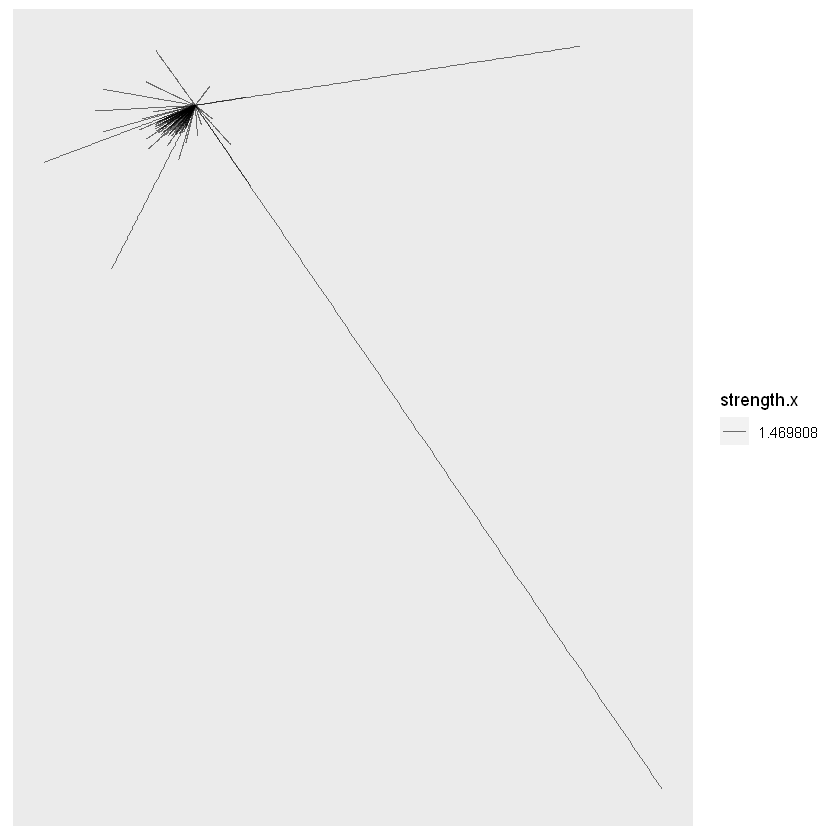

In [38]:
# Filter ties for betweenness around the median
ggraph(network2, layout = "with_kk") + 
  geom_edge_link(aes(alpha = strength.x, filter = strength.x < 1.47 & strength.x > 1.46))

# 4) Similarity Analysis:

`geom_smooth()` using formula 'y ~ x'



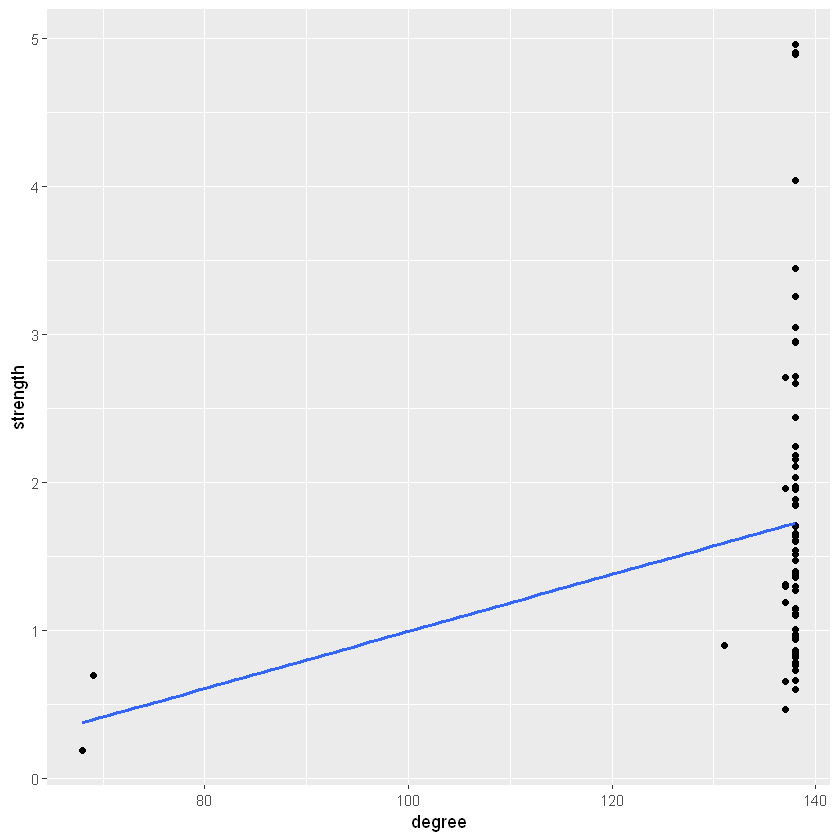

In [59]:
# Visualizing correlation
ggplot(data=node_w_d_s, mapping=aes(x = degree, y = strength)) + geom_point() + geom_smooth(method='lm', se = FALSE)

In [60]:
# There is a very weak and positive correlationship between strength and degree
paste0('Pearson Correlation Coefficient: ',cor(node_w_d_s$degree,node_w_d_s$strength))

[1] "Pearson Correlation Coefficient: 0.216620332184018"

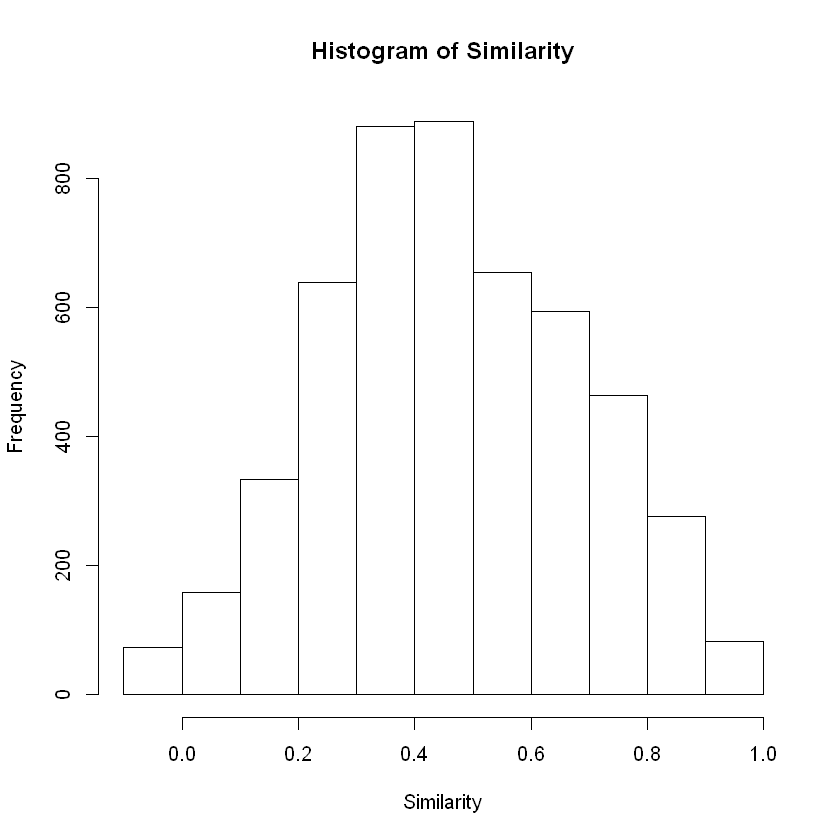

In [61]:
# The weighted adjacency matrix
A = as_adjacency_matrix(network2, attr="weight", names=FALSE)

# Computing the Pearson Correlationship matrix of A
S = cor(as.matrix(A))

# Setting the diagonal of S of 0
diag(S) = 0

# Flatten S to be a vector
flat_S = as.vector(S)

# Plot a histogram of similarities
hist = hist(flat_S, xlab = "Similarity", main = "Histogram of Similarity")

# 5) Distance Analysis:

In [66]:
# Compute a distance matrix
D = 1-S

# Obtain a distance object 
d = as.dist(D)

# Run average-linkage clustering method and plot the dendrogram 
cc = hclust(d, method = "ward.D2")

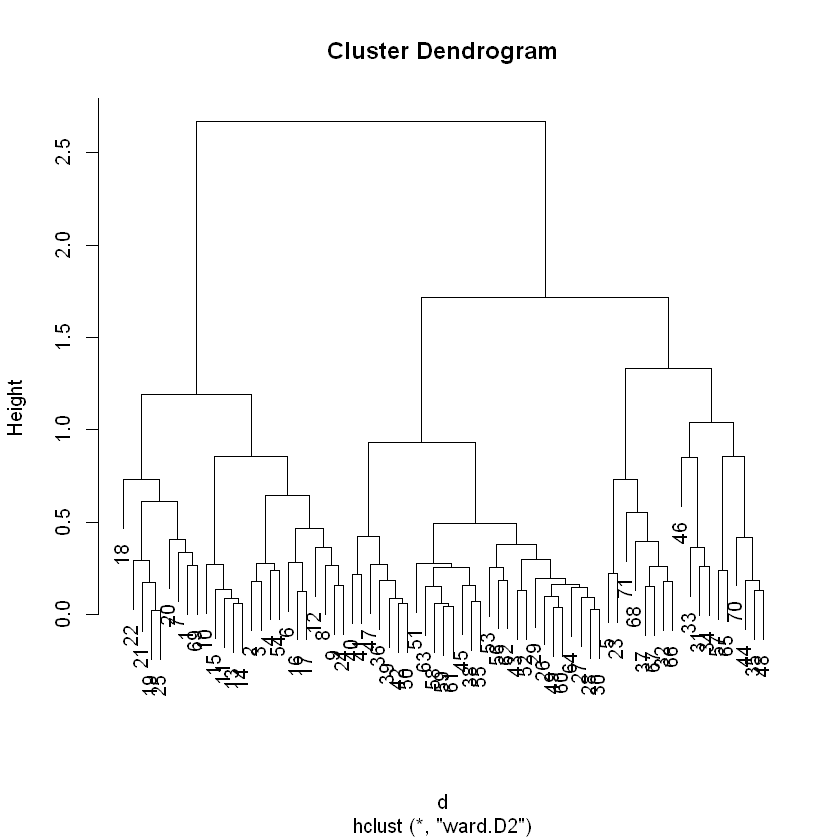

In [67]:
plot(cc)

In [73]:
# Cut the dendrogram tree into 20 clusters
cls = cutree(cc, k = 5)

# Add cluster information to nodes
nodes_w_d_s_c = node_w_d_s %>% mutate(cluster = cls)

In [75]:
# Calculate properties of each cluster
nodes_w_d_s_c %>%
  # Group by cluster
  group_by(cluster) %>%
  # Calculate summary statistics
  summarize(
    # Number of nodes
    size = n(), 
    # Mean degree
    avg_degree = mean(degree),
    # Mean strength
    avg_strength = mean(strength)
  ) %>% 
  # Arrange rows by decreasing size
  arrange(desc(size))

cluster,size,avg_degree,avg_strength
<int>,<int>,<dbl>,<dbl>
4,28,137.6429,1.150106
2,16,137.9375,2.812605
5,10,137.8000,1.162760
1,9,137.8889,2.234827
3,8,120.5000,1.308007


In [77]:
# Including cluster number
V(network2)$cluster = nodes_w_d_s_c$cluster

# 6) Analysing TOP 100 Edges based on weight:

In [108]:
# Top 30 relationships in terms of weight
ties_joined2 = head(ties_joined[order(-ties_joined$weight),],100)

network3 = graph_from_data_frame(ties_joined2, directed = TRUE)
V(network3)$cluster = nodes_w_d_s_c$cluster

network3

Warning message in vattrs[[name]][index] <- value:
"number of items to replace is not a multiple of replacement length"


IGRAPH de76e33 DNW- 60 100 -- 
+ attr: name (v/c), cluster (v/n), weight (e/n), betweenness (e/n),
| degree.x (e/n), strength.x (e/n), degree.y (e/n), strength.y (e/n)
+ edges from de76e33 (vertex names):
[1] SECURITIES, COMMODITY CONTRACTS, AND INVESTMENTS->FUNDS, TRUSTS, AND OTHER FINANCIAL VEHICLES
[2] OIL AND GAS EXTRACTION                          ->PETROLEUM AND COAL PRODUCTS                
[3] CHEMICAL PRODUCTS                               ->PLASTICS AND RUBBER PRODUCTS               
[4] FARMS                                           ->FOOD AND BEVERAGE AND TOBACCO PRODUCTS     
[5] PRIMARY METALS                                  ->FABRICATED METAL PRODUCTS                  
+ ... omitted several edges

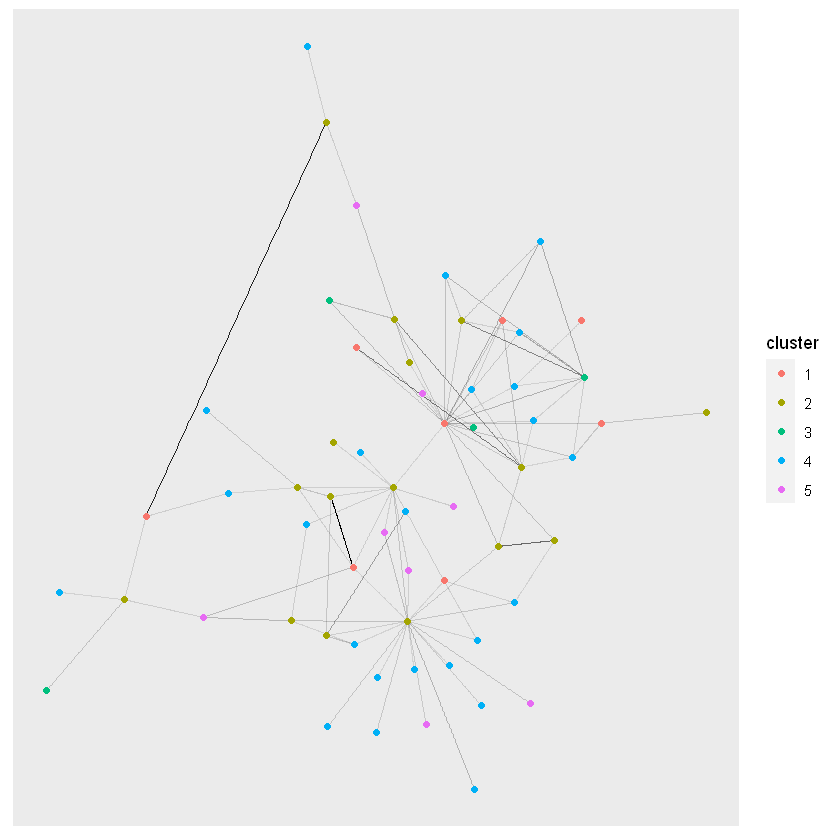

In [126]:
# Update the plot
ggraph(network3, layout = "with_kk") + 
  geom_edge_link(aes(alpha = weight), show.legend=FALSE) +  
  geom_node_point(aes(color = factor(cluster))) + 
  labs(color = "cluster")

In [117]:
p = simpleNetwork(ties_joined2, height="100px", width="100px",        
        Source = 1,                 # column number of source
        Target = 2,                 # column number of target
        linkDistance = 100,          # distance between node. Increase this value to have more space between nodes
        charge = -50,                # numeric value indicating either the strength of the node repulsion (negative value) or attraction (positive value)
        fontSize = 14,               # size of the node names
        fontFamily = "serif",       # font og node names
        linkColour = "#666",        # colour of edges, MUST be a common colour for the whole graph
        nodeColour = "#69b3a2",     # colour of nodes, MUST be a common colour for the whole graph
        opacity = 0.9,              # opacity of nodes. 0=transparent. 1=no transparency
        zoom = T                    # Can you zoom on the figure?
        )

In [118]:
saveWidget(p, file="C:/Users/jpolancoroque/Desktop/IESEG/02. Second Semester/Social Network Analysis/Group/networkInteractive.html")

In [191]:
t2 <- transitivity(network2, type="global")
t2

[1] 0.9992056

In [187]:
t2 <- transitivity(network3, type="average")
t2

[1] 0.482824

In [183]:
mean(t2, na.rm = TRUE)

[1] 0.482824

In [190]:
E(network3)

+ 100/100 edges from de76e33 (vertex names):
[1] SECURITIES, COMMODITY CONTRACTS, AND INVESTMENTS->FUNDS, TRUSTS, AND OTHER FINANCIAL VEHICLES
[2] OIL AND GAS EXTRACTION                          ->PETROLEUM AND COAL PRODUCTS                
[3] CHEMICAL PRODUCTS                               ->PLASTICS AND RUBBER PRODUCTS               
[4] FARMS                                           ->FOOD AND BEVERAGE AND TOBACCO PRODUCTS     
[5] PRIMARY METALS                                  ->FABRICATED METAL PRODUCTS                  
[6] CHEMICAL PRODUCTS                               ->TEXTILE MILLS AND TEXTILE PRODUCT MILLS    
[7] INSURANCE CARRIERS AND RELATED ACTIVITIES       ->FEDERAL GENERAL GOVERNMENT (NONDEFENSE)    
+ ... omitted several edges